In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
pd.set_option("display.max_rows", 1000)    #設定最大能顯示1000rows
pd.set_option("display.max_columns", 1000)   #設定最大能顯示1000columns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder       #轉字串為數字
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [2]:
train_link = '/kaggle/input/siim-isic-melanoma-classification/train.csv'
train_df = pd.read_csv(train_link)
test_link = '/kaggle/input/siim-isic-melanoma-classification/test.csv'
test_df = pd.read_csv(test_link)

new_names = ['dcm_name', 'ID', 'sex', 'age', 'body_part', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

print(train_df.head())
print(test_df.head())

       dcm_name          ID     sex   age        body_part diagnosis  \
0  ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1  ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2  ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3  ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4  ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   

  benign_malignant  target  
0           benign       0  
1           benign       0  
2           benign       0  
3           benign       0  
4           benign       0  
       dcm_name          ID     sex   age        body_part
0  ISIC_0052060  IP_3579794    male  70.0              NaN
1  ISIC_0052349  IP_7782715    male  40.0  lower extremity
2  ISIC_0058510  IP_7960270  female  55.0            torso
3  ISIC_0073313  IP_6375035  female  50.0            torso
4  ISIC_0073502  IP_0589375  female  45.0  lower extremity


In [3]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

train_df['age'] = train_df['age'].fillna(train_df['age'].median())            # age補缺失值: 平均
train_df['sex'] = train_df['sex'].fillna('no')                                # sex補缺失值: no
train_df['body_part'] = train_df['body_part'].fillna('no')                    #body_part補缺失值: no

test_df['body_part'] = test_df['body_part'].fillna('no')                    #body_part補缺失值: no

dcm_name              0
ID                    0
sex                  65
age                  68
body_part           527
diagnosis             0
benign_malignant      0
target                0
dtype: int64
dcm_name       0
ID             0
sex            0
age            0
body_part    351
dtype: int64


In [4]:
train_df['target'] = train_df['target'].astype('int64')     
train_df.dtypes

dcm_name             object
ID                   object
sex                  object
age                 float64
body_part            object
diagnosis            object
benign_malignant     object
target                int64
dtype: object

In [5]:
numaaa = 0 

def TheWhole(name='', num = 0.0) : 
  for i in range(len(train_df)) : 
    if train_df[name][i] == 1 : 
       num = num + 1.0
    i = i + 1 
     
  print(name,': ',num)

TheWhole('target', numaaa) 

target :  584.0


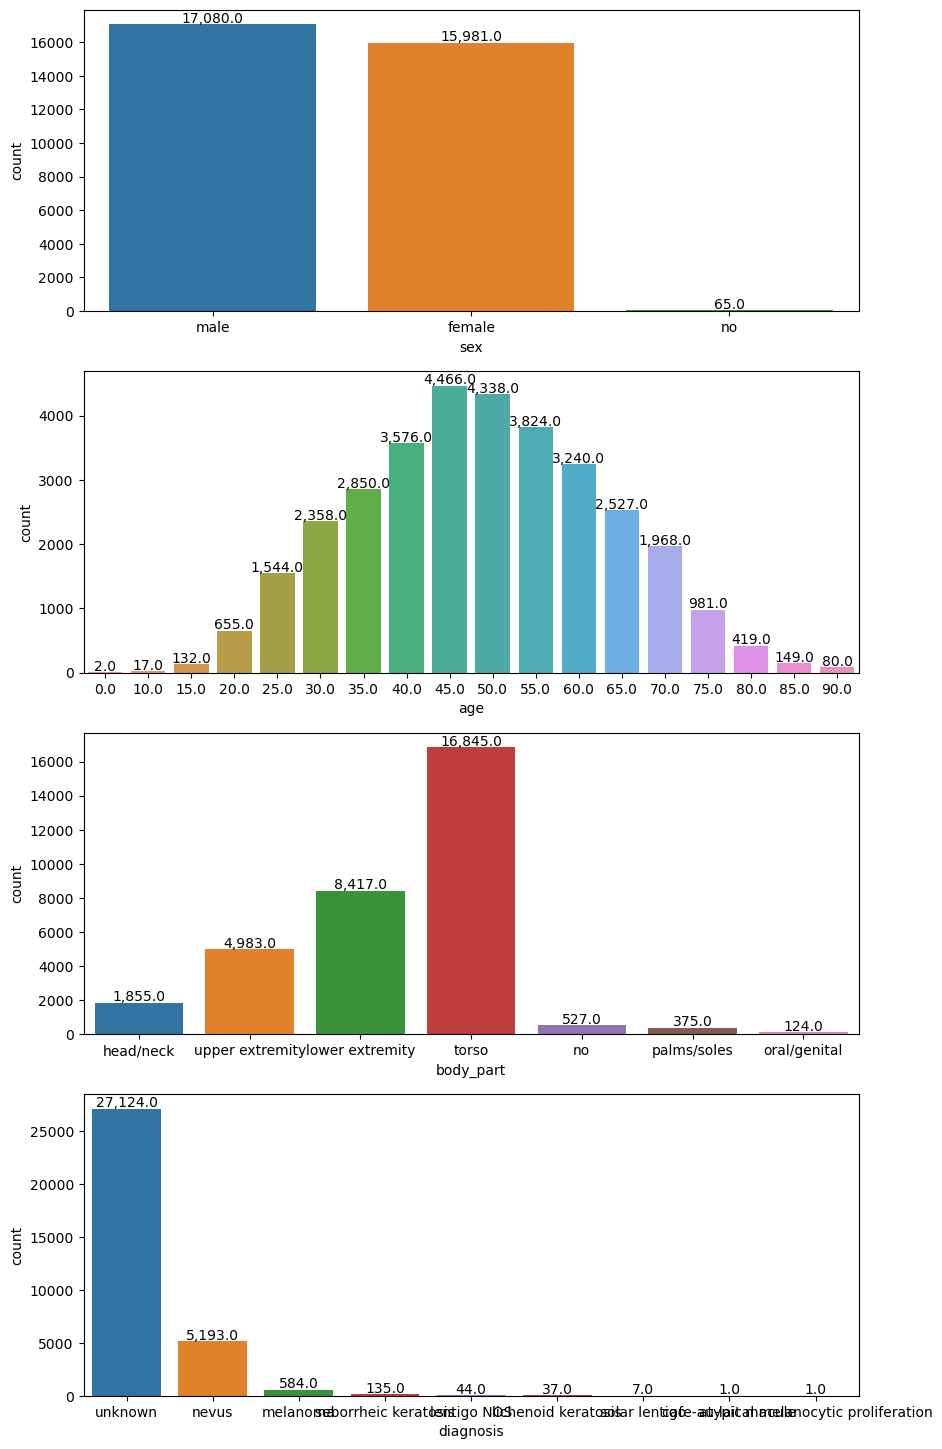

In [6]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,18))          # 特徵視覺化
a = sns.countplot(x='sex', data=train_df, ax=ax1)
b = sns.countplot(x='age', data=train_df, ax=ax2)
c = sns.countplot(x='body_part', data=train_df, ax=ax3)
d = sns.countplot(x='diagnosis', data=train_df, ax=ax4)

def pic_name(haha):
    for p in haha.patches:
        haha.annotate(format(p.get_height(), ','), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), ha = 'center', va = 'center', 
               xytext = (0, 4), textcoords = 'offset points')
pic_name(a)
pic_name(b)
pic_name(c)
pic_name(d)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD from sys.path while we load stuff.


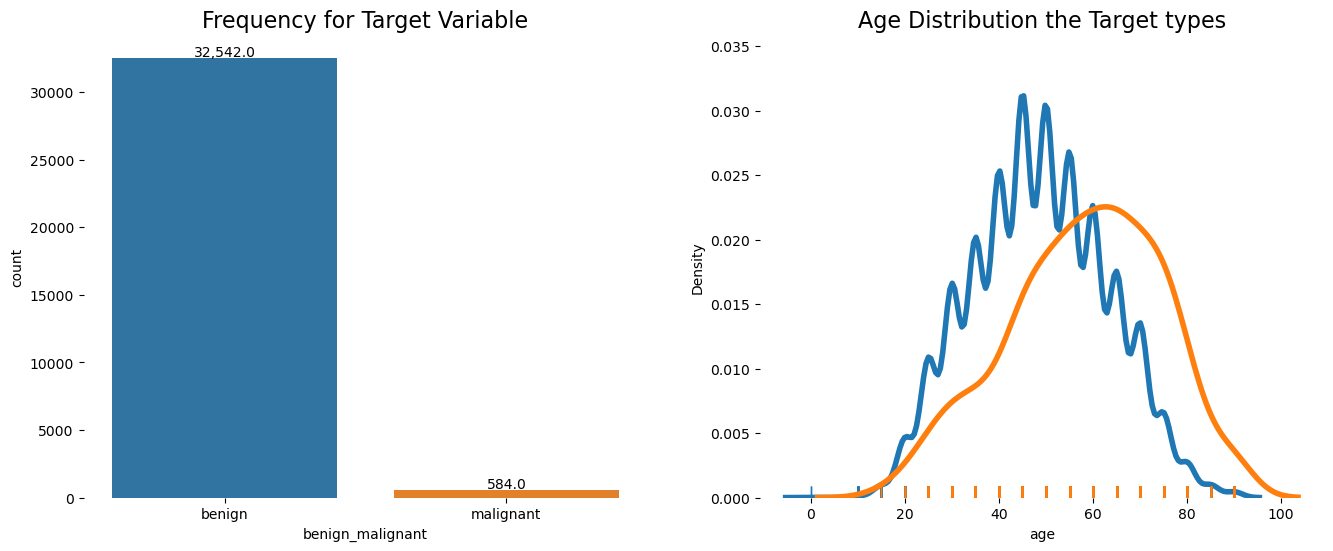

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

#描繪benign_malignant的直方圖
a = sns.countplot(data = train_df, x = 'benign_malignant', ax=ax1)
#描繪target=0的曲線
b = sns.distplot(a = train_df[train_df['target']==0]['age'], ax=ax2,
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign')
#描繪target=1的曲線
c = sns.distplot(a = train_df[train_df['target']==1]['age'], ax=ax2, 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
#標題名稱
ax1.set_title('Frequency for Target Variable', fontsize=16)
ax2.set_title('Age Distribution the Target types', fontsize=16)
sns.despine(left=True, bottom=True);

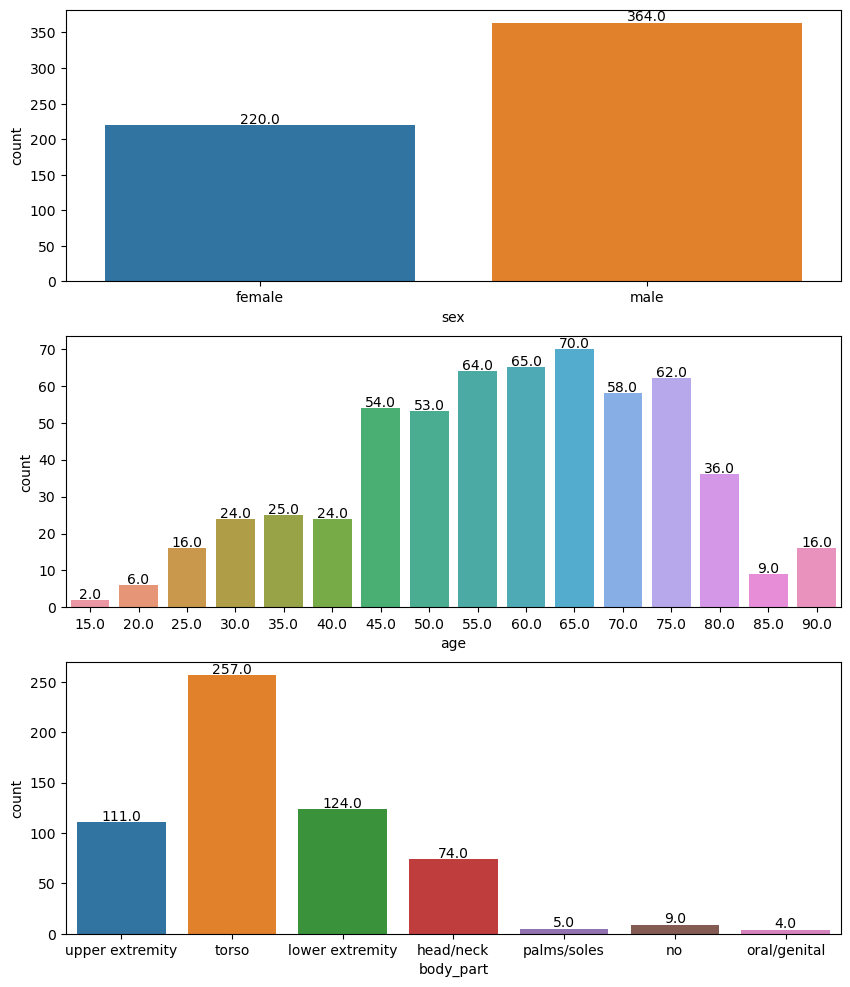

In [10]:
male_df = train_df[train_df['target'] == 1]   #只列出惡性的dataframe

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,12))          # 惡性特徵視覺化
a = sns.countplot(x='sex', data=male_df, ax=ax1)
b = sns.countplot(x='age', data=male_df, ax=ax2)
c = sns.countplot(x='body_part', data=male_df, ax=ax3)

def pic_name(haha):
    for p in haha.patches:
        haha.annotate(format(p.get_height(), ','), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), ha = 'center', va = 'center', 
               xytext = (0, 4), textcoords = 'offset points')
pic_name(a)
pic_name(b)
pic_name(c)

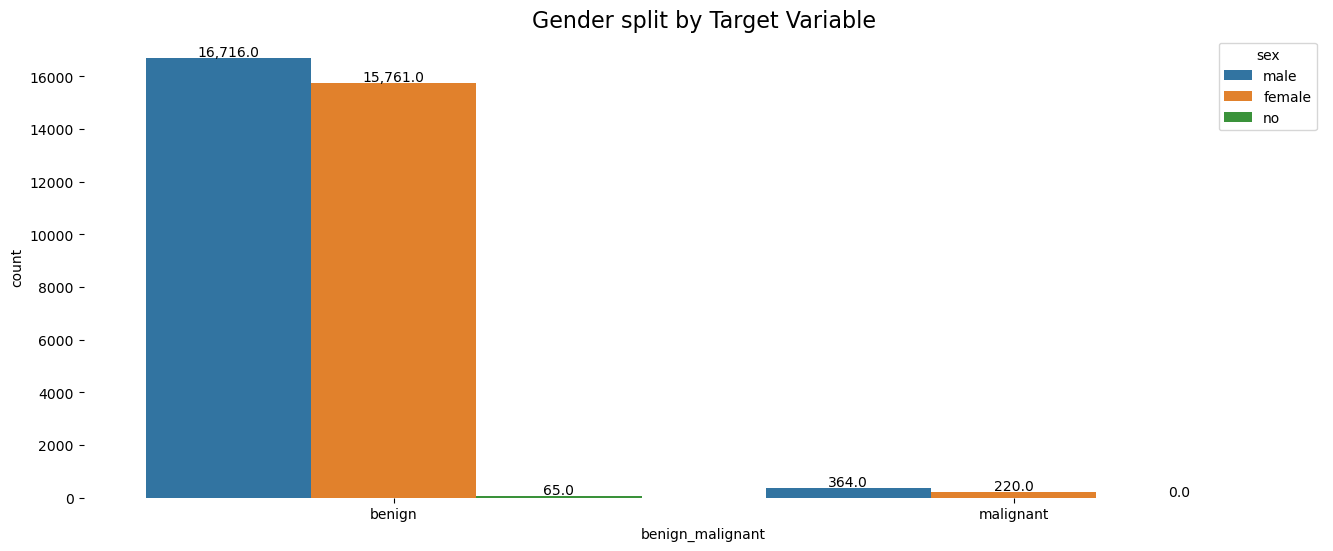

In [11]:
#繪製良性男女數量分布 & 惡性男女數量分布

plt.figure(figsize=(16, 6))
a = sns.countplot(data=train_df, x='benign_malignant', hue='sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


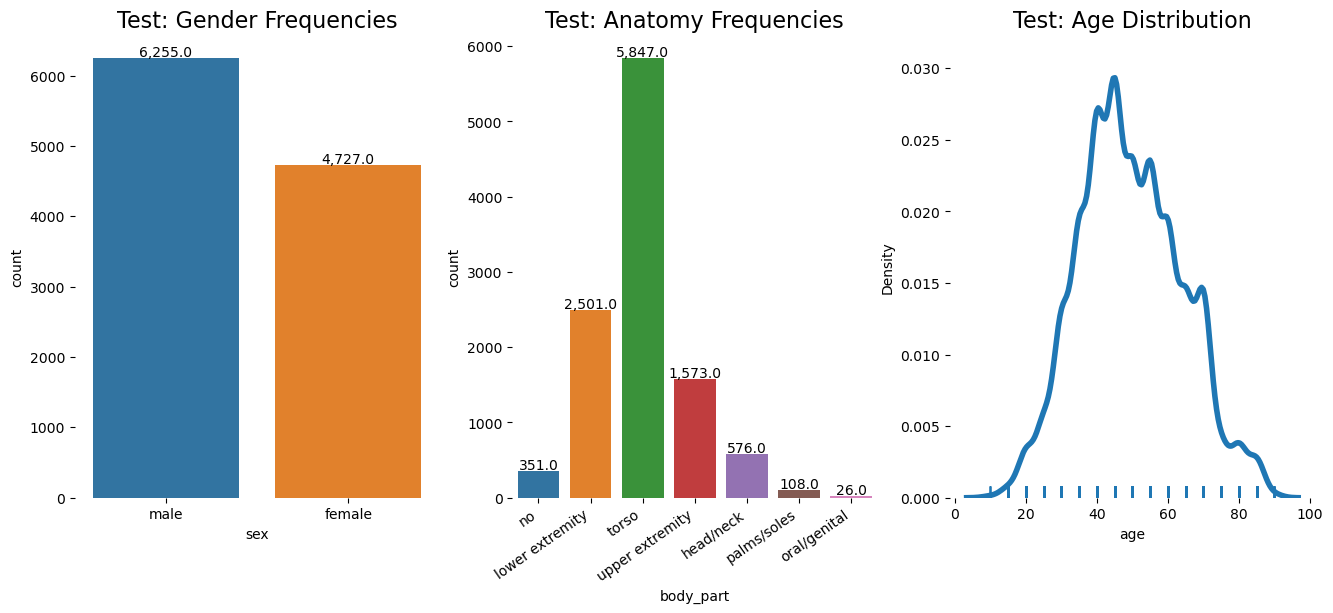

In [12]:
# Testdata測試集的特徵統計圖

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 6))

a = sns.countplot(x='sex', data = test_df, ax=ax1)
b = sns.countplot(x='body_part', data = test_df, ax=ax2)

c = sns.distplot(a = test_df['age'], ax=ax3, hist=False, rug=True, kde_kws=dict(linewidth=4))

def pic_name(haha):
    for p in haha.patches:
        haha.annotate(format(p.get_height(), ','), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), ha = 'center', va = 'center', 
               xytext = (0, 4), textcoords = 'offset points')
pic_name(a)
pic_name(b)
    
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

In [7]:
# input image 
directory = '/kaggle/input/siim-isic-melanoma-classification'

path_train = directory + '/train/' + train_df['dcm_name'] + '.dcm'
path_test = directory + '/test/' + test_df['dcm_name'] + '.dcm'

# Append to the original dataframes
train_df['path_dicom'] = path_train
test_df['path_dicom'] = path_test

# === JPEG ===

# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test
train_df.head()


,dcm_name,ID,sex,age,body_part,diagnosis,benign_malignant,target,path_dicom,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/kaggle/input/siim-isic-melanoma-classificatio...,/kaggle/input/siim-isic-melanoma-classificatio...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/kaggle/input/siim-isic-melanoma-classificatio...,/kaggle/input/siim-isic-melanoma-classificatio...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/kaggle/input/siim-isic-melanoma-classificatio...,/kaggle/input/siim-isic-melanoma-classificatio...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/kaggle/input/siim-isic-melanoma-classificatio...,/kaggle/input/siim-isic-melanoma-classificatio...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/kaggle/input/siim-isic-melanoma-classificatio...,/kaggle/input/siim-isic-melanoma-classificatio...


# ***JPEG檔影像輸入 & 影像增強***

In [4]:
import cv2 
import os
from keras.applications.densenet import preprocess_input, DenseNet121

img_size = 256

train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'

# 獲取圖片Function
def get_image(img_name, is_train=True,transform=False):
    
    if is_train:
        path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
    else:
        path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/' 
        
    if transform:
        img = change_img_color(path, img_name)
    else:
        path = os.path.join(path,img_name+'.jpg')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (200,200))
        
    return img

# 輸出圖片Fumction
def show_data(df,rows,cols,is_train=True,transform=False):
    
    df.reset_index(inplace=True,drop=True)
    fig = plt.figure(figsize=(6,6),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_name = df.loc[i-1,'dcm_name']
            
            title = 'DCM name:' +df.loc[i-1,'dcm_name']+'\n'\
              +'Patient id: '+df.loc[i-1,'ID']+'\n'\
              +'Site: '+str(df.loc[i-1,'body_part'])+'\n'\
              +'Sex: '+str(df.loc[i-1,'sex'])+'\n'\
              +'Approximate Age: '+str(int(df.loc[i-1,'age']))
            
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_name,is_train,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
            
    return fig

In [5]:
# 改變圖片顏色
def change_img_color(path, img_id):
    path = os.path.join(path,img_id+'.jpg')
    
    img = cv2.imread(path)
 
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       # 灰階                               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)        # HSV 
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)        # 亮色
    
    # 高斯模糊
    img= cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0) ,256/10), -4, 128)

    # 固定
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                       
    new_img = cv2.resize(img, (200,200))
    new_img = preprocess_input(new_img)
    return new_img

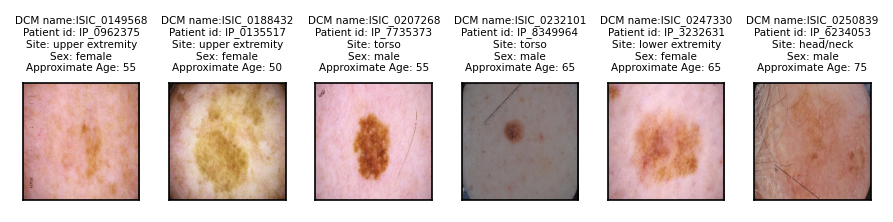

In [6]:
# 原始影像
fig = show_data(train_df[train_df['target'] == 1].iloc[:6,:],1,6)    
fig.tight_layout()

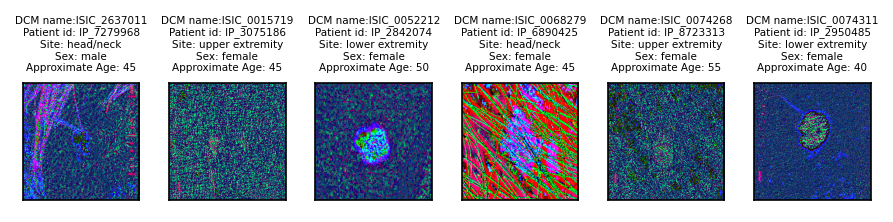

In [14]:
# 增強影像
fig = show_data(train_df[train_df['benign_malignant']=='benign'].iloc[:6,:],1,6,transform=True)
fig.tight_layout()

# **DICOM影像輸出 & 影像增強****

/opt/conda/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


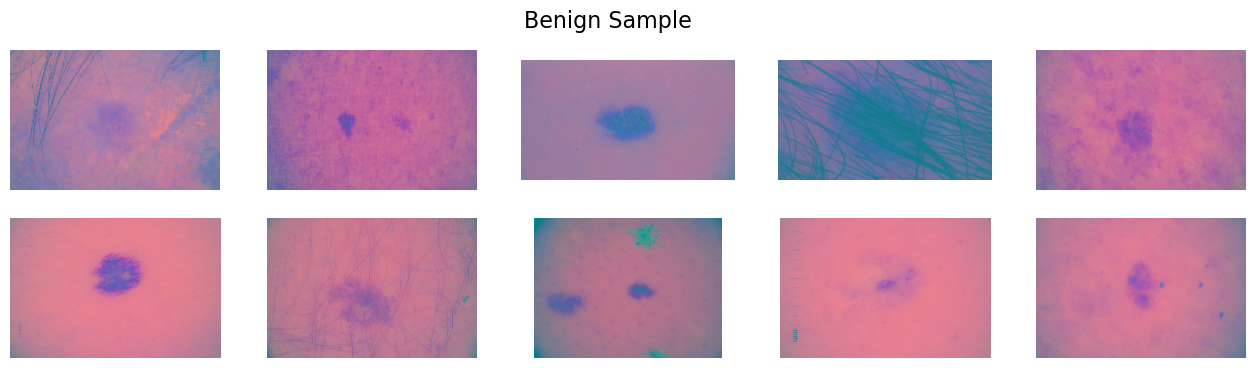

In [13]:
import pydicom          # 輸出DICOM原始影像

def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(16,4))

    for k, path in enumerate(data['path_dicom'][:n]):
        image = pydicom.dcmread(path)
        image = image.pixel_array
        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')
       
show_images(train_df[train_df['target'] == 0], n=10, rows=2, cols=5, title='Benign Sample')

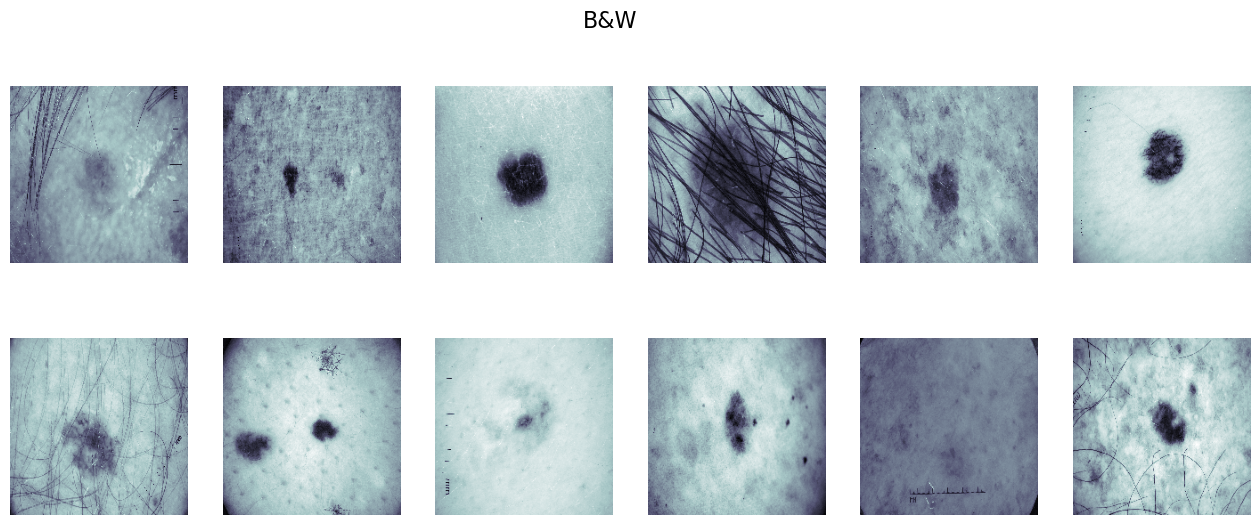

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))         # 灰階影像
plt.suptitle("B&W", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

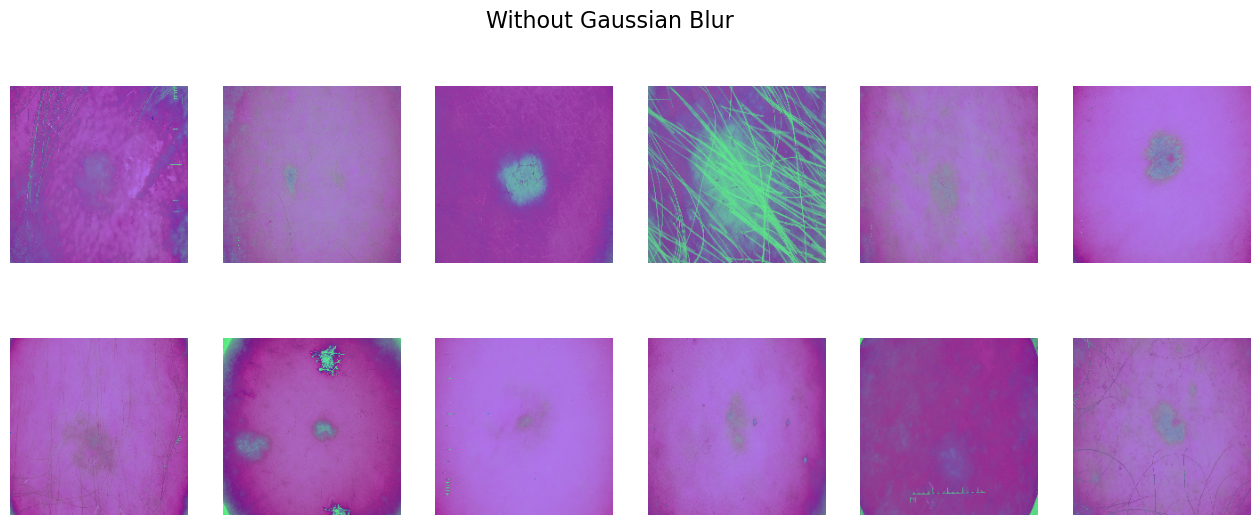

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))         # HSV 
plt.suptitle("Without Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')